In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_blobs

## Generating Data

In [67]:
N = 128
M = 20
Tp = 80
Td = 120
Tc = Tp + Td

possible_values = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / (2**0.5)

X_true = np.empty((M, Tc), dtype=complex) 
for i in range(Tc):
    x = np.random.choice(possible_values, size=M, p=[0.25, 0.25, 0.25, 0.25])
    X_true[:, i] = x

X_true = np.array(X_true)

X_true.shape

(20, 200)

In [63]:
H_real = np.random.normal(0, 1, (N, M)) / np.sqrt(2)
H_imag = np.random.normal(0, 1, (N, M)) / np.sqrt(2)
H = H_real + 1j * H_imag

H.shape

(128, 20)

In [64]:
sigma = 0.1
noise = np.random.normal(0, sigma, (N, Tc)) + 1j * np.random.normal(0, sigma, (N, Tc))
R = H @ X_true + noise/(2**0.5)
Y = np.sign(np.real(R))  +1j * np.sign(np.imag(R))

Y.shape, noise.shape

((128, 200), (128, 200))

## Channel Estimation

In [73]:
X_tp = X_true[:, :Tp]
Y_tp = Y[:, :Tp]
noise_tp = noise[:, :Tp]


X_tp.shape, Y_tp.shape, noise_tp.shape

((20, 80), (128, 80), (128, 80))

In [74]:
X_tp_tilde = np.concatenate([
    np.concatenate((np.real(X_tp), np.imag(X_tp)), axis=1),
    np.concatenate((-1*np.imag(X_tp), np.real(X_tp)), axis=1)
])

Y_tp_tilde = np.concatenate((np.real(Y_tp), np.imag(Y_tp)), axis=1)
H_tilde = np.concatenate((np.real(H), np.imag(H)), axis=1)
noise_tp_tilde = np.concatenate((np.real(noise_tp), np.imag(noise_tp)), axis=1)


Y_tp_tilde.shape, H_tilde.shape, X_tp_tilde.shape, noise_tp_tilde.shape



((128, 160), (128, 40), (40, 160), (128, 160))

In [121]:
# Generate synthetic data
X = X_tp_tilde.transpose()
y = Y_tp_tilde[0]  # Convert labels to -1 and 1

# Train a soft-margin SVM
C = 100  # Penalty parameter
clf = SVC(kernel='linear', C=C)
clf.fit(X, y)

# Get the hyperplane parameters
w = clf.coef_[0]
b = clf.intercept_[0]

w, b

(array([-0.42702713,  0.09558844, -0.19437612, -0.5402705 , -0.05904667,
        -0.13016575, -0.54220981,  0.09341287,  0.11587227, -0.13014292,
        -0.16521635, -0.22848833, -0.73801033, -0.60582568, -0.74940413,
         0.04779067,  0.22573819, -0.11295014, -0.10986092,  0.42861029,
        -0.70025624,  0.12812279, -0.59741736, -0.06643594, -0.18924405,
        -0.16312603,  0.18925673, -0.10102945, -0.71997717,  0.70069285,
        -0.42046336, -0.04415755, -0.04245812, -0.62776363, -0.05169699,
         0.23791583,  0.38337474, -0.40766016,  0.44700384,  0.08114651]),
 -0.21454774116355416)

In [142]:
H_hat = np.zeros((N, 2*M))

X_matrix = X_tp_tilde.transpose()
for row in range(N):
    y_row = Y_tp_tilde[row]

    C = 1  # Penalty parameter
    clf = SVC(kernel='linear', C=C)
    clf.fit(X_matrix, y_row)

    # Get the hyperplane parameters
    w = clf.coef_[0]
    b = clf.intercept_[0]

    H_hat[row] = w

H_hat.shape, H_hat

((128, 40),
 array([[-0.43199966,  0.07423122, -0.21245373, ..., -0.30984143,
          0.4168587 ,  0.04369209],
        [ 0.27008024,  0.01180754,  0.33367873, ...,  0.13072314,
          0.38676589, -0.40005197],
        [ 0.53800608, -0.30984778,  0.32282675, ..., -0.1596827 ,
          0.46010884, -0.04984438],
        ...,
        [ 0.42892029, -0.01032439, -0.06878922, ..., -0.43468575,
         -0.11846148, -0.49122296],
        [-0.51378502,  0.24901919,  0.40399716, ...,  0.25390843,
         -0.72866642,  0.48957076],
        [ 0.28626373, -0.38627405,  0.60496662, ...,  0.28316751,
         -0.1207403 ,  0.03441788]]))

In [147]:
H_hat_complex = H_hat[:, :M] + 1j * H_hat[:, M:]
norm_H_hat = np.linalg.norm(H_hat_complex)
H_hat_complex = (H_hat_complex / norm_H_hat) * 51

H_hat_complex

array([[-0.92095871-1.43729922j,  0.15824987+0.22454243j,
        -0.4529196 -1.20178593j, ..., -0.21320773-0.66053562j,
        -0.21913642+0.88868045j,  0.81756926+0.093145j  ],
       [ 0.5757707 -0.06731672j,  0.02517192+0.64814766j,
         0.7113532 -0.43503362j, ...,  0.1096857 +0.2786822j ,
         0.8383252 +0.82452707j,  1.18851919-0.85285102j],
       [ 1.14694857+1.17625021j, -0.66054916-0.16031673j,
         0.68821839-0.5093086j , ..., -0.56383081-0.34041966j,
         1.11956712+0.98088329j,  0.6148516 -0.10626077j],
       ...,
       [ 0.91439397-1.07585852j, -0.02201005+0.61240589j,
        -0.14664833+0.57681645j, ..., -0.13813235-0.92668507j,
         2.37279698-0.25254217j, -0.71607809-1.04721393j],
       [-1.09531288-0.1914458j ,  0.53087169+0.30541077j,
         0.86126157+0.56588896j, ...,  0.70088338+0.54129483j,
        -0.72119608-1.55340791j, -1.0543096 +1.0436917j ],
       [ 0.61027148+0.6338816j , -0.82347855-0.27064155j,
         1.28969842+0.9941394j

In [172]:
def get_H_hat(X, y):
    N=128
    M=20

    X_matrix = X_tp_tilde.transpose()
    for row in range(N):
        y_row = Y_tp_tilde[row]

        C = 0.01  # Penalty parameter
        clf = SVC(kernel='linear', C=C)
        clf.fit(X_matrix, y_row)

        # Get the hyperplane parameters
        w = clf.coef_[0]
        b = clf.intercept_[0]

        H_hat[row] = w

    H_hat_complex = H_hat[:, :M] + 1j * H_hat[:, M:]
    norm_H_hat = np.linalg.norm(H_hat_complex)
    H_hat_complex = (H_hat_complex / norm_H_hat) * 51

    return H_hat_complex
    

In [173]:
H_hat_complex = get_H_hat(X_tp_tilde, Y_tp_tilde)

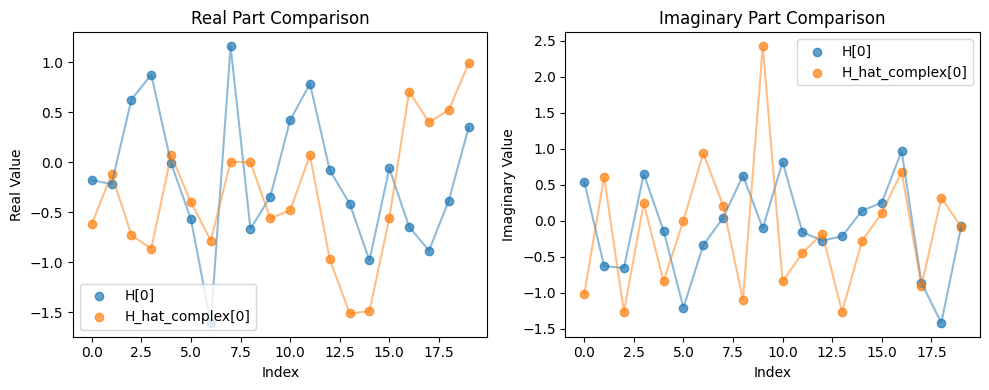

In [174]:
plt.figure(figsize=(10, 4))

# Plotting the real parts
plt.subplot(1, 2, 1)
plt.title('Real Part Comparison')
plt.scatter(range(len(np.real(H[0]))), np.real(H[0]), label='H[0]', alpha=0.7)
plt.plot(range(len(np.real(H[0]))), np.real(H[0]), alpha=0.5)  # Line for H[0]
plt.scatter(range(len(np.real(H_hat_complex[0]))), np.real(H_hat_complex[0]), label='H_hat_complex[0]', alpha=0.7)
plt.plot(range(len(np.real(H_hat_complex[0]))), np.real(H_hat_complex[0]), alpha=0.5)  # Line for H_hat_complex[0]
plt.xlabel('Index')
plt.ylabel('Real Value')
plt.legend()

# Plotting the imaginary parts
plt.subplot(1, 2, 2)
plt.title('Imaginary Part Comparison')
plt.scatter(range(len(np.imag(H[0]))), np.imag(H[0]), label='H[0]', alpha=0.7)
plt.plot(range(len(np.imag(H[0]))), np.imag(H[0]), alpha=0.5)  # Line for H[0]
plt.scatter(range(len(np.imag(H_hat_complex[0]))), np.imag(H_hat_complex[0]), label='H_hat_complex[0]', alpha=0.7)
plt.plot(range(len(np.imag(H_hat_complex[0]))), np.imag(H_hat_complex[0]), alpha=0.5)  # Line for H_hat_complex[0]
plt.xlabel('Index')
plt.ylabel('Imaginary Value')
plt.legend()

plt.tight_layout()
plt.show()

## Data Detection


In [176]:
X_td = X_true[:, -Td:]
noise_td = noise[:, -Td:]
Y_td = Y[:, -Td:]

X_td_tilde = np.concatenate((np.real(X_td), np.imag(X_td)))

H_tilde = np.concatenate([
    np.concatenate((np.real(H), np.imag(H)), axis=1),
    np.concatenate((-1*np.imag(H), np.real(H)), axis=1)
])

Y_td_tilde = np.concatenate((np.real(Y), np.imag(Y)))
noise_td_tilde = np.concatenate((np.real(noise_td), np.imag(noise_td)))


Y_td_tilde.shape, H_tilde.shape, X_td_tilde.shape, noise_td_tilde.shape

((256, 200), (256, 40), (40, 120), (256, 120))